In [271]:
# encoding: UTF-8
# Copyright 2017 Google.com
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#import tensorflow as tf
#from tensorflow.contrib import layers
#from tensorflow.contrib import rnn  # rnn stuff temporarily in contrib, moving back to code in TF 1.1
import os
import time
import math
import numpy as np
import my_txtutils as txt
#tf.set_random_seed(0)

In [400]:

# model parameters
#
# Usage:
#   Training only:
#         Leave all the parameters as they are
#         Disable validation to run a bit faster (set validation=False below)
#         You can follow progress in Tensorboard: tensorboard --log-dir=log
#   Training and experimentation (default):
#         Keep validation enabled
#         You can now play with the parameters anf follow the effects in Tensorboard
#         A good choice of parameters ensures that the testing and validation curves stay close
#         To see the curves drift apart ("overfitting") try to use an insufficient amount of
#         training data (shakedir = "shakespeare/t*.txt" for example)
#
nb_epoch=10
SEQLEN = 30
BATCHSIZE = 200
ALPHASIZE = txt.ALPHASIZE
INTERNALSIZE = 256
NLAYERS = 3
learning_rate = 0.001  # fixed learning rate
dropout_pkeep = 0.8    # some dropout

In [401]:
# encoding: UTF-8
# Copyright 2017 Google.com
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import glob
import sys

# size of the alphabet that we work with
ALPHASIZE = 98


# Specification of the supported alphabet (subset of ASCII-7)
# 10 line feed LF
# 32-64 numbers and punctuation
# 65-90 upper-case letters
# 91-97 more punctuation
# 97-122 lower-case letters
# 123-126 more punctuation
def convert_from_alphabet(a):
    """Encode a character
    :param a: one character
    :return: the encoded value
    """
    if a == 9:
        return 1
    if a == 10:
        return 127 - 30  # LF
    elif 32 <= a <= 126:
        return a - 30
    else:
        return 0  # unknown


# encoded values:
# unknown = 0
# tab = 1
# space = 2
# all chars from 32 to 126 = c-30
# LF mapped to 127-30
def convert_to_alphabet(c, avoid_tab_and_lf=False):
    """Decode a code point
    :param c: code point
    :param avoid_tab_and_lf: if True, tab and line feed characters are replaced by '\'
    :return: decoded character
    """
    if c == 1:
        return 32 if avoid_tab_and_lf else 9  # space instead of TAB
    if c == 127 - 30:
        return 92 if avoid_tab_and_lf else 10  # \ instead of LF
    if 32 <= c + 30 <= 126:
        return c + 30
    else:
        return 0  # unknown


def encode_text(s):
    """Encode a string.
    :param s: a text string
    :return: encoded list of code points
    """
    return list(map(lambda a: convert_from_alphabet(ord(a)), s))


def decode_to_text(c, avoid_tab_and_lf=False):
    """Decode an encoded string.
    :param c: encoded list of code points
    :param avoid_tab_and_lf: if True, tab and line feed characters are replaced by '\'
    :return:
    """
    return "".join(map(lambda a: chr(convert_to_alphabet(a, avoid_tab_and_lf)), c))


def sample_from_probabilities(probabilities, topn=ALPHASIZE):
    """Roll the dice to produce a random integer in the [0..ALPHASIZE] range,
    according to the provided probabilities. If topn is specified, only the
    topn highest probabilities are taken into account.
    :param probabilities: a list of size ALPHASIZE with individual probabilities
    :param topn: the number of highest probabilities to consider. Defaults to all of them.
    :return: a random integer
    """
    p = np.squeeze(probabilities)
    p[np.argsort(p)[:-topn]] = 0
    p = p / np.sum(p)
    return np.random.choice(ALPHASIZE, 1, p=p)[0]


def rnn_minibatch_sequencer(raw_data, batch_size, sequence_size, nb_epochs):
    """
    Divides the data into batches of sequences so that all the sequences in one batch
    continue in the next batch. This is a generator that will keep returning batches
    until the input data has been seen nb_epochs times. Sequences are continued even
    between epochs, apart from one, the one corresponding to the end of raw_data.
    The remainder at the end of raw_data that does not fit in an full batch is ignored.
    :param raw_data: the training text
    :param batch_size: the size of a training minibatch
    :param sequence_size: the unroll size of the RNN
    :param nb_epochs: number of epochs to train on
    :return:
        x: one batch of training sequences
        y: on batch of target sequences, i.e. training sequences shifted by 1
        epoch: the current epoch number (starting at 0)
    """
    data = np.array(raw_data)
    data_len = data.shape[0]
    # using (data_len-1) because we must provide for the sequence shifted by 1 too
    nb_batches = (data_len - 1) // (batch_size * sequence_size)
    assert nb_batches > 0, "Not enough data, even for a single batch. Try using a smaller batch_size."
    rounded_data_len = nb_batches * batch_size * sequence_size
    xdata = np.reshape(data[0:rounded_data_len], [batch_size, nb_batches * sequence_size])
    ydata = np.reshape(data[1:rounded_data_len + 1], [batch_size, nb_batches * sequence_size])

    for epoch in range(nb_epochs):
        for batch in range(nb_batches):
            x = xdata[:, batch * sequence_size:(batch + 1) * sequence_size]
            y = ydata[:, batch * sequence_size:(batch + 1) * sequence_size]
            x = np.roll(x, -epoch, axis=0)  # to continue the text from epoch to epoch (do not reset rnn state!)
            y = np.roll(y, -epoch, axis=0)
            yield x, y, epoch


def find_book(index, bookranges):
    return next(
        book["name"] for book in bookranges if (book["start"] <= index < book["end"]))


def find_book_index(index, bookranges):
    return next(
        i for i, book in enumerate(bookranges) if (book["start"] <= index < book["end"]))


def print_learning_learned_comparison(X, Y, losses, bookranges, batch_loss, batch_accuracy, epoch_size, index, epoch):
    """Display utility for printing learning statistics"""
    print()
    # epoch_size in number of batches
    batch_size = X.shape[0]  # batch_size in number of sequences
    sequence_len = X.shape[1]  # sequence_len in number of characters
    start_index_in_epoch = index % (epoch_size * batch_size * sequence_len)
    for k in range(batch_size):
        index_in_epoch = index % (epoch_size * batch_size * sequence_len)
        decx = decode_to_text(X[k], avoid_tab_and_lf=True)
        decy = decode_to_text(Y[k], avoid_tab_and_lf=True)
        bookname = find_book(index_in_epoch, bookranges)
        formatted_bookname = "{: <10.40}".format(bookname)  # min 10 and max 40 chars
        epoch_string = "{:4d}".format(index) + " (epoch {}) ".format(epoch)
        loss_string = "loss: {:.5f}".format(losses[k])
        print_string = epoch_string + formatted_bookname + " │ {} │ {} │ {}"
        print(print_string.format(decx, decy, loss_string))
        index += sequence_len
    # box formatting characters:
    # │ \u2502
    # ─ \u2500
    # └ \u2514
    # ┘ \u2518
    # ┴ \u2534
    # ┌ \u250C
    # ┐ \u2510
    format_string = "└{:─^" + str(len(epoch_string)) + "}"
    format_string += "{:─^" + str(len(formatted_bookname)) + "}"
    format_string += "┴{:─^" + str(len(decx) + 2) + "}"
    format_string += "┴{:─^" + str(len(decy) + 2) + "}"
    format_string += "┴{:─^" + str(len(loss_string)) + "}┘"
    footer = format_string.format('INDEX', 'BOOK NAME', 'TRAINING SEQUENCE', 'PREDICTED SEQUENCE', 'LOSS')
    print(footer)
    # print statistics
    batch_index = start_index_in_epoch // (batch_size * sequence_len)
    batch_string = "batch {}/{} in epoch {},".format(batch_index, epoch_size, epoch)
    stats = "{: <28} batch loss: {:.5f}, batch accuracy: {:.5f}".format(batch_string, batch_loss, batch_accuracy)
    print()
    print("TRAINING STATS: {}".format(stats))


class Progress:
    """Text mode progress bar.
    Usage:
            p = Progress(30)
            p.step()
            p.step()
            p.step(start=True) # to restart form 0%
    The progress bar displays a new header at each restart."""
    def __init__(self, maxi, size=100, msg=""):
        """
        :param maxi: the number of steps required to reach 100%
        :param size: the number of characters taken on the screen by the progress bar
        :param msg: the message displayed in the header of the progress bat
        """
        self.maxi = maxi
        self.p = self.__start_progress(maxi)()  # () to get the iterator from the generator
        self.header_printed = False
        self.msg = msg
        self.size = size

    def step(self, reset=False):
        if reset:
            self.__init__(self.maxi, self.size, self.msg)
        if not self.header_printed:
            self.__print_header()
        next(self.p)

    def __print_header(self):
        print()
        format_string = "0%{: ^" + str(self.size - 6) + "}100%"
        print(format_string.format(self.msg))
        self.header_printed = True

    def __start_progress(self, maxi):
        def print_progress():
            # Bresenham's algorithm. Yields the number of dots printed.
            # This will always print 100 dots in max invocations.
            dx = maxi
            dy = self.size
            d = dy - dx
            for x in range(maxi):
                k = 0
                while d >= 0:
                    print('=', end="", flush=True)
                    k += 1
                    d -= dx
                d += dy
                yield k

        return print_progress


def read_data_files(directory, validation=True):
    """Read data files according to the specified glob pattern
    Optionnaly set aside the last file as validation data.
    No validation data is returned if there are 5 files or less.
    :param directory: for example "data/*.txt"
    :param validation: if True (default), sets the last file aside as validation data
    :return: training data, validation data, list of loaded file names with ranges
     If validation is
    """
    codetext = []
    bookranges = []
    shakelist = glob.glob(directory, recursive=True)
    for shakefile in shakelist:
        shaketext = open(shakefile, "r")
        print("Loading file " + shakefile)
        start = len(codetext)
        codetext.extend(encode_text(shaketext.read()))
        end = len(codetext)
        bookranges.append({"start": start, "end": end, "name": shakefile.rsplit("/", 1)[-1]})
        shaketext.close()

    if len(bookranges) == 0:
        sys.exit("No training data has been found. Aborting.")

    # For validation, use roughly 90K of text,
    # but no more than 10% of the entire text
    # and no more than 1 book in 5 => no validation at all for 5 files or fewer.

    # 10% of the text is how many files ?
    total_len = len(codetext)
    validation_len = 0
    nb_books1 = 0
    for book in reversed(bookranges):
        validation_len += book["end"]-book["start"]
        nb_books1 += 1
        if validation_len > total_len // 10:
            break

    # 90K of text is how many books ?
    validation_len = 0
    nb_books2 = 0
    for book in reversed(bookranges):
        validation_len += book["end"]-book["start"]
        nb_books2 += 1
        if validation_len > 90*1024:
            break

    # 20% of the books is how many books ?
    nb_books3 = len(bookranges) // 5

    # pick the smallest
    nb_books = min(nb_books1, nb_books2, nb_books3)

    if nb_books == 0 or not validation:
        cutoff = len(codetext)
    else:
        cutoff = bookranges[-nb_books]["start"]
    valitext = codetext[cutoff:]
    codetext = codetext[:cutoff]
    return codetext, valitext, bookranges


def print_data_stats(datalen, valilen, epoch_size):
    datalen_mb = datalen/1024.0/1024.0
    valilen_kb = valilen/1024.0
    print("Training text size is {:.2f}MB with {:.2f}KB set aside for validation.".format(datalen_mb, valilen_kb)
          + " There will be {} batches per epoch".format(epoch_size))


def print_validation_header(validation_start, bookranges):
    bookindex = find_book_index(validation_start, bookranges)
    books = ''
    for i in range(bookindex, len(bookranges)):
        books += bookranges[i]["name"]
        if i < len(bookranges)-1:
            books += ", "
    print("{: <60}".format("Validating on " + books), flush=True)


def print_validation_stats(loss, accuracy):
    print("VALIDATION STATS:                                  loss: {:.5f},       accuracy: {:.5f}".format(loss,
                                                                                                           accuracy))


def print_text_generation_header():
    print()
    print("┌{:─^111}┐".format('Generating random text from learned state'))


def print_text_generation_footer():
    print()
    print("└{:─^111}┘".format('End of generation'))


def frequency_limiter(n, multiple=1, modulo=0):
    def limit(i):
        return i % (multiple * n) == modulo*multiple
    return limit


In [402]:
# load data, either shakespeare, or the Python source of Tensorflow itself
shakedir = "txts/*.txt"
#shakedir = "../tensorflow/**/*.py"
codetext, valitext, bookranges = txt.read_data_files(shakedir, validation=True)

Loading file txts\acts_new.txt
Loading file txts\gal_eph_new.txt
Loading file txts\heb_new.txt
Loading file txts\jam_jud_new.txt
Loading file txts\john_new.txt
Loading file txts\jud_rev_new.txt
Loading file txts\luke_8_john_new.txt
Loading file txts\mark01_new.txt
Loading file txts\matt02_new.txt
Loading file txts\matt_new.txt
Loading file txts\phil_col_new.txt
Loading file txts\thes_tim_new.txt
Loading file txts\tit_phl_new.txt


In [403]:
# display some stats on the data
epoch_size = len(codetext) // (BATCHSIZE * SEQLEN)
txt.print_data_stats(len(codetext), len(valitext), epoch_size)

Training text size is 5.83MB with 384.30KB set aside for validation. There will be 1018 batches per epoch


In [ ]:
!pip install https://github.com/kpu/kenlm/archive/master.zip

In [404]:
# model
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, layers):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.gru = nn.GRU(input_size, hidden_size, layers)

    def forward(self, input, hidden):
        # combined = torch.cat((input, hidden), 1)
        output, hidden = self.gru(input, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(NLAYERS, BATCHSIZE, self.hidden_size, device=device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru = GRU(ALPHASIZE, INTERNALSIZE, NLAYERS)

In [405]:
# loss fn
criterion = nn.NLLLoss()

#from ok_seq2seq import EncoderRNN \
#                        ,DecoderRNN \
#                        ,AttnDecoderRNN \
#                        ,evaluateRandomly \
#                        ,teacher_forcing_ratio 
'''
Parameters
input_size – The number of expected features in the input x
hidden_size – The number of features in the hidden state h
num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two GRUs together to form a stacked GRU, 
    with the second GRU taking in outputs of the first GRU and computing the final results. Default: 1
bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
dropout – If non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer, with dropout probability equal to dropout. Default: 0
bidirectional – If True, becomes a bidirectional GRU. Default: False

rnn = nn.GRU(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

input of shape (seq_len, batch, input_size): tensor containing the features of the input sequence. 
    The input can also be a packed variable length sequence. See torch.nn.utils.rnn.pack_padded_sequence() for details.

h_0 of shape (num_layers * num_directions, batch, hidden_size): tensor containing the initial hidden state for each element in the batch. 
    Defaults to zero if not provided. If the RNN is bidirectional, num_directions should be 2, else it should be 1
    
output of shape (seq_len, batch, num_directions * hidden_size): tensor containing the output features h_t from the last layer of the GRU, for each t. 
    If a torch.nn.utils.rnn.PackedSequence has been given as the input, the output will also be a packed sequence. 
    For the unpacked case, the directions can be separated using output.view(seq_len, batch, num_directions, hidden_size), with forward and backward being direction 0 and 1 respectively.
    Similarly, the directions can be separated in the packed case.

h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len
    Like output, the layers can be separated using h_n.view(num_layers, num_directions, batch, hidden_size).
    
Shape:
Input: (N, C)(N,C) where C = number of classes, or (N, C, d_1, d_2, ..., d_K)(N,C,d 
Target: (N)(N) where each value is 0 \leq \text{targets}[i] \leq C-10≤targets[i]≤C−1 , or (N, d_1, d_2, ..., d_K)(N,d 
Output: scalar. If reduction is 'none', then the same size as the target: (N)(N) , or (N, d_1, d_2, ..., d_K)(N,d 
'''

"\nParameters\ninput_size – The number of expected features in the input x\nhidden_size – The number of features in the hidden state h\nnum_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two GRUs together to form a stacked GRU, \n    with the second GRU taking in outputs of the first GRU and computing the final results. Default: 1\nbias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True\nbatch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False\ndropout – If non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer, with dropout probability equal to dropout. Default: 0\nbidirectional – If True, becomes a bidirectional GRU. Default: False\n\nrnn = nn.GRU(10, 20, 2)\ninput = torch.randn(5, 3, 10)\nh0 = torch.randn(2, 3, 20)\noutput, hn = rnn(input, h0)\n\ninput of shape (seq_len, batch, input_size): tensor containing the features of th

In [412]:
# training fn
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = gru.initHidden()
    softmax = nn.LogSoftmax(dim=1)
    fc_layer = nn.Linear(INTERNALSIZE, ALPHASIZE)        
    gru.zero_grad()
    
    output, hidden = gru(line_tensor, hidden)
    #print(f'gos={output.size()}, is={line_tensor.size()}')
    output = fc_layer(output)
    #print(f'fc={output.size()}, ls={line_tensor.size()}')
    output = softmax(output)
    #print(f'sm={output.size()}, cs[2:]={category_tensor.size()}')
    input=output.transpose(0,1).transpose(1,2)
    loss = criterion(input, category_tensor) # N (batch),C
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in gru.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output.transpose(0,1), loss.item()

In [413]:
import torch
a=txt.rnn_minibatch_sequencer(codetext, BATCHSIZE, SEQLEN, nb_epochs=10).__next__()

In [415]:
def mb2t(rows):
    rows=rows.transpose()
    tensor = torch.zeros(rows.shape[0], rows.shape[1], ALPHASIZE, device=device)
    for i, row in enumerate(rows):
        for j, letter_code in enumerate(row):
            tensor[i][j][letter_code] = 1
    return tensor

def lin2txt(lt):
    return ''.join([chr(txt.convert_to_alphabet(c))  if c != 0 else '' for c in lt])


In [426]:
# init train

import time
import math
  # product = reduce((lambda x, y: x * y), [1, 2, 3, 4])


print_every = 250
plot_every = 500


# Keep track of losses for plotting
current_loss = 0
all_losses = []
iter=0
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


epoch 0 of  10 (0m 1s) 2659.7578  okunwengiapu (14) / iAqf\\n()Neee==C""""IIIIICCCCv(30) ✗  okunwengiapu m
epoch 0 of  10 (0m 1s) 2659.7578 bara mi nwose o(15) / vvvvx&xB
|ssZZQQQ7==kkYYY"YYYY(30) ✗ ara mi nwose om
epoch 0 of  10 (5m 31s) 1324.5800 wo sobie mun ok(15) / BBBGGGGGGGGGGn\\--[![tNNNN000J(30) ✗ o sobie mun oku
epoch 0 of  10 (5m 31s) 1324.5800 o goyegoye nemi(15) / GGGG$5555_???`555_????00]]]]&&(30) ✗  goyegoye nemim
epoch 0 of  10 (10m 56s) 2649.1596  isiapu ma bere(15) / dd!nnnnnn3ccIA&&T___FFF3888Abt(30) ✗ isiapu ma beren
epoch 0 of  10 (10m 56s) 2649.1596 now naa kirikir(15) / ff@@@Sq[kk###aFFFFFnn~nnnnnnnn(30) ✗ ow naa kirikiri
epoch 0 of  10 (15m 11s) 1324.5790 aist be ere bu (15) / OOOO???MFz999nntnn000000008888(30) ✗ ist be ere bu o
epoch 0 of  10 (15m 11s) 1324.5790 ini vinpiki se (15) / L6XXXX++mmmmmmm3))p""6+++zCCzz(30) ✗ ni vinpiki se s
epoch 0 of  10 (19m 38s) 2649.1579  mun dumo bie c(15) / KK2^ooll;;BB,,oooSZPP:]]YYY2ww(30) ✗ mun dumo bie ch
epoch 0 of  10 (1

KeyboardInterrupt: 

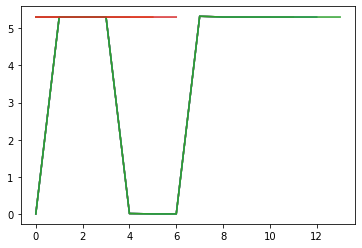

In [435]:
start = time.time()
plt.figure()
vloss=[]
VALI_SEQLEN = 30
for x, y_, epoch in txt.rnn_minibatch_sequencer(codetext, BATCHSIZE, SEQLEN, nb_epochs=nb_epoch):
    #category, line, category_tensor, line_tensor = randomTrainingExample()
    category =  [lin2txt(l) for l in y_]
    lines = [lin2txt(l) for l in x]
    line_tensor=mb2t(x)
    output, loss = train(torch.tensor(y_, device=device, dtype=torch.long), line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess = [lin2txt([ch.argmax(dim=0) for ch in line]) for line in output]
        for i in range(2):
            correct = '✓' if guess[i] == category[i] else '✗ %s' % category[i] 
            closs = '%.4f' % current_loss
            print(f'epoch {epoch} of  {nb_epoch} ({timeSince(start)}) {closs} {lines[i]}({len(lines[i])}) / {guess[i]}({len(guess[i])}) {correct}' )
 
    # Add current loss avg to list of losses
    if iter % plot_every == 0 and len(valitext) > 0:
        all_losses.append(current_loss / plot_every)
        plt.plot(all_losses)
        current_loss = 0
        vali_x, vali_y, _ = next(txt.rnn_minibatch_sequencer(valitext, BATCHSIZE, VALI_SEQLEN, 1))  # all data in 1 batch
        line_tensor = mb2t(vali_x)
        output, loss = train(torch.tensor(vali_y, device=device, dtype=torch.long), line_tensor)
        vloss.append(loss)
        plt.plot(vloss)      
    iter += 1

In [ ]:
%matplotlib inline